In [1]:
import requests
import pandas as pd
import altair as alt
from bs4 import BeautifulSoup

In [2]:
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [3]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### Trout vs. Everybody

In [4]:
df = pd.read_csv("./input/war_daily_bat.txt")

In [5]:
qualified_df = df[(df.age < 43) & (df.age > 18)]
qualified_df = qualified_df[~pd.isnull(qualified_df.age)]
qualified_df = qualified_df[(qualified_df.PA > 350) | (qualified_df.name_common == 'Mike Trout')]

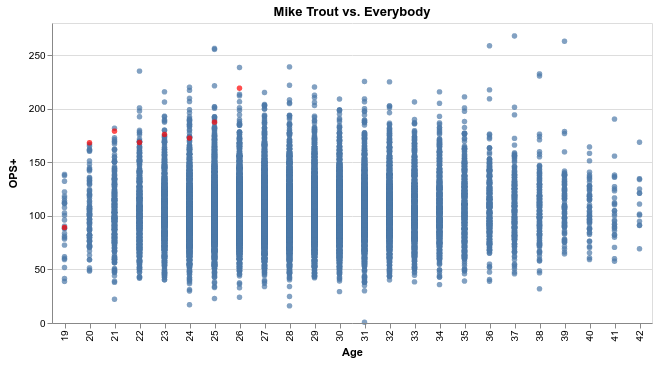

In [6]:
base = alt.Chart(qualified_df, title="Mike Trout vs. Everybody").properties(width=600, height=300).encode(
    x=alt.X("age:O", axis=alt.Axis(title="Age")),
    y=alt.Y("OPS_plus:Q", axis=alt.Axis(title="OPS+")),
    tooltip=["name_common", "OPS_plus"]
)

field = base.mark_circle().transform_filter(alt.datum.name_common != 'Mike Trout')
trout = base.mark_circle(color="red").transform_filter(alt.datum.name_common == 'Mike Trout')

field + trout

### Trout vs. HOF

In [7]:
hof_html = requests.get("https://www.baseball-reference.com/awards/hof.shtml").text

In [8]:
hof_soup = BeautifulSoup(hof_html, 'html.parser')

In [9]:
hof_rows = hof_soup.find("table").find_all("tr")[1:]

In [10]:
hof_players = dict()
for row in hof_rows:
    cells = row.find_all("td")
    if cells[3].string == 'Player':
        hof_players[cells[0]['data-append-csv']] = cells[0].string

In [13]:
hof_df = pd.DataFrame(list(hof_players.items()), columns=["player_ID", "name_common"])

In [14]:
hof_df.to_csv("./hall-of-fame-players.csv", index=False)

In [21]:
hof_stats = df[df.player_ID.isin(hof_df.player_ID)]

In [22]:
trout = df[df.name_common == 'Mike Trout']

In [23]:
hof_plus_trout = hof_stats.append(trout)

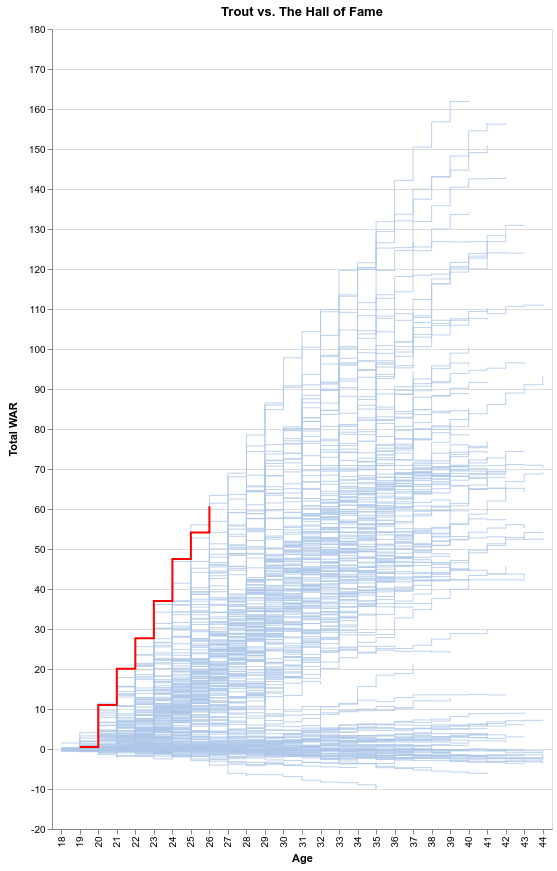

In [24]:
base = alt.Chart(hof_plus_trout, title="Mike Trout vs. The Hall of Fame").transform_window(
    window=[alt.WindowFieldDef(op='sum', field='WAR', **{'as': 'TotalWAR'})],
    groupby=["player_ID"],
).transform_filter(alt.datum.age < 45).transform_filter(
    alt.datum.age > 17
).properties(
    width=500,
    height=800
)

field = base.mark_line(interpolate='step-before', strokeWidth=0.8).transform_filter(
    alt.datum.name_common != 'Mike Trout'
).encode(
    x=alt.X('age:O', axis=alt.Axis(title="Age")),
    y=alt.Y('TotalWAR:Q', axis=alt.Axis(title="Total WAR")),
    color=alt.Color(
        "player_ID:N",
        legend=None,
        scale=alt.Scale(
            domain=list(hof_plus_trout.player_ID.unique()),
            range=['#aec7e8' for i in hof_plus_trout.player_ID.unique()]
        )
    )
)
trout = base.mark_line(color="red", interpolate='step-before').transform_filter(alt.datum.name_common == 'Mike Trout').encode(
    x='age:O',
    y='TotalWAR:Q',
)

field + trout